In [1]:
from typing import Optional, Tuple, Union
import os
import uuid

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import whisper

Download GTZAN dataset from `https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz` and add uncompressed result to `data/raw/` folder

In [2]:
labels_map = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9,
}

In [3]:
# Remove corrupted file
# os.remove("data/raw/genres/jazz/jazz.00054.wav")

In [4]:
raw_annotations = []
for label in labels_map:
    for file in os.listdir(f"data/raw/genres/{label}"):
        annotation = {
            "filepath": f"data/raw/genres/{label}/{file}",
            "label": labels_map[label]
        }
        raw_annotations.append(annotation)

raw_annotations_df = pd.DataFrame(raw_annotations)

In [5]:
# Visualise audio sample

def plot_waveform(waveform: torch.Tensor, sample_rate: Union[int, str]):
    frames = waveform.shape[1]
    time_axis = torch.arange(0, frames) / sample_rate
    figure, axis = plt.subplots(1, 1)
    axis.plot(time_axis, waveform[0], linewidth=1)
    axis.grid(True)
    plt.title("Waveform")
    plt.show(block=False)

In [6]:
SAMPLE_RATE = 16000

/var/folders/zh/8mw3jn4j7tj7lv8fjyp9q0_40000gn/T/ipykernel_17606/445536498.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  plot_waveform(torch.tensor((waveform,)), SAMPLE_RATE)


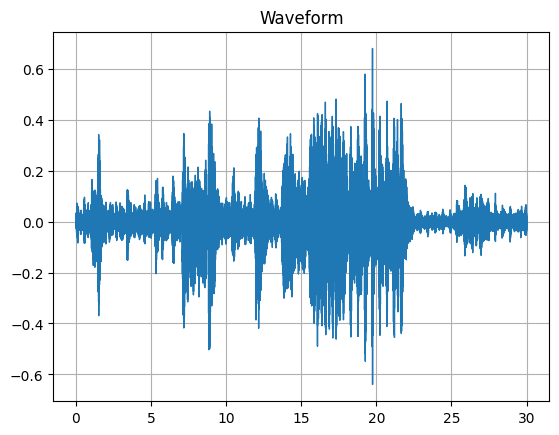

In [7]:
# Since we'll be using whisper.log_mel_spectrogram we need to resample original 22500 Hz to 16000 Hz
waveform = whisper.load_audio("data/raw/genres/jazz/jazz.00000.wav", sr=SAMPLE_RATE)
plot_waveform(torch.tensor((waveform,)), SAMPLE_RATE)

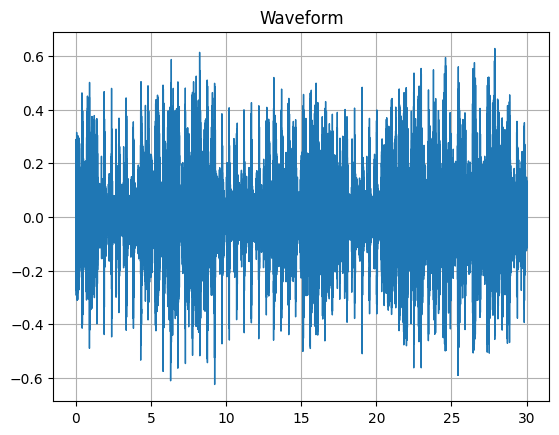

In [8]:
waveform = whisper.load_audio("data/raw/genres/reggae/reggae.00000.wav", sr=SAMPLE_RATE)
plot_waveform(torch.tensor((waveform,)), SAMPLE_RATE)

In [9]:
TRAIN_FRAC = 0.9

train_raw_annotations_df, test_raw_annotations_df = train_test_split(
    raw_annotations_df,
    train_size=int(TRAIN_FRAC * len(raw_annotations_df)),
    stratify=raw_annotations_df["label"],
    random_state=1995,
)

In [10]:
# Each original audio file is ~30 seconds; this is sliced into N_SLICES smaller files
# Motivation: don't need 30 seconds to discern genre + (artificially) expands dataset
N_SLICES = 10

In [11]:
def create_sliced_audio_samples(
    raw_annotations_df: pd.DataFrame,
    output_dir: str,
    sample_rate: Union[str, int],
    n_slices: int,
) -> None:
    """
    Parameters
    ----------
    raw_annotations_df : pandas.DataFrame
        Columns:
            Name: filepath, dtype: object
            Name: label, dtype: int64
    """
    # check if audio files already create before
    try:
        os.makedirs(f"data/preprocessed/{output_dir}/audio", exist_ok=False)
    except OSError:
        return

    preprocessed_annotations = []
    for _, row in raw_annotations_df.iterrows():
        waveform = whisper.load_audio(row["filepath"], sr=sample_rate)
        frames_per_slice = len(waveform) // n_slices
        for i in range(n_slices):
            waveform_slice = waveform[i * frames_per_slice : i * frames_per_slice + frames_per_slice]
            filepath = f"data/preprocessed/{output_dir}/audio/{str(uuid.uuid4())}.wav"
            torchaudio.save(
                filepath,
                torch.tensor((waveform_slice, )),
                sample_rate,
            )
            preprocessed_annotations.append({"filepath": filepath, "label": row["label"]})

    # save annotations to as csv file
    pd.DataFrame(preprocessed_annotations).to_csv(f"data/preprocessed/{output_dir}/annotations.csv")

In [12]:
create_sliced_audio_samples(
    train_raw_annotations_df,
    output_dir="train",
    sample_rate=SAMPLE_RATE,
    n_slices=N_SLICES,
)

In [13]:
create_sliced_audio_samples(
    test_raw_annotations_df,
    output_dir="test",
    sample_rate=SAMPLE_RATE,
    n_slices=N_SLICES,
)

In [14]:
class SlicedGTZANDataset(Dataset):
    def __init__(self, train: bool, mean_and_std: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        dir = "train" if train else "test"
        self._annotations_df = pd.read_csv(f"data/preprocessed/{dir}/annotations.csv")
        self._mean_and_std = mean_and_std

    def __len__(self):
        return len(self._annotations_df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        waveform = whisper.load_audio(self._annotations_df.iloc[idx]["filepath"])
        waveform_padded_or_trimmed = whisper.pad_or_trim(waveform, length=3*SAMPLE_RATE)
        mel = whisper.log_mel_spectrogram(waveform_padded_or_trimmed).unsqueeze(0)
        mel = (mel - self._mean_and_std[0]) / self._mean_and_std[1] if self._mean_and_std else mel
        return mel, self._annotations_df.iloc[idx]["label"]

In [15]:
train_dataset = SlicedGTZANDataset(train=True)

In [16]:
def plot_mel_log_spectrogram(mel: torch.Tensor):
    plt.imshow(mel.squeeze(0), aspect="auto")
    plt.title("Mel Log Spectrogram")
    plt.show()

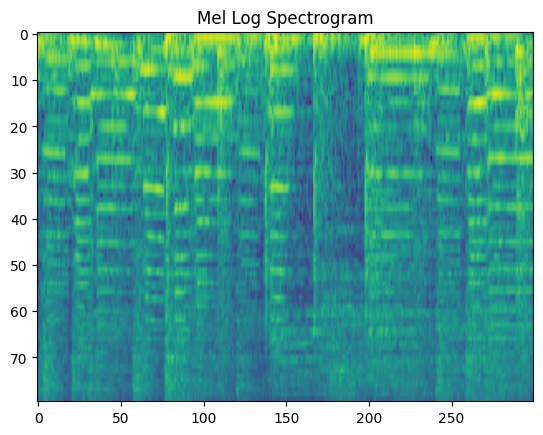

In [17]:
plot_mel_log_spectrogram(train_dataset[0][0])

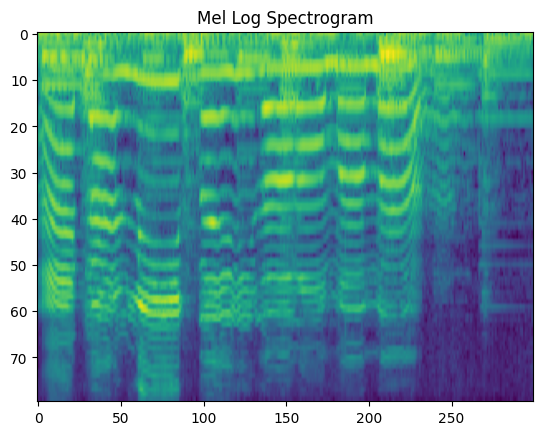

In [18]:
plot_mel_log_spectrogram(train_dataset[8989][0])

In [19]:
try:
    train_mean = torch.load("train_mean.pth")
except FileNotFoundError:
    train_total = torch.zeros(1, train_dataset[0][0].shape[2])
    for d in train_dataset:
        train_total += torch.sum(d[0], dim=1)
    train_mean = train_total / (train_dataset[0][0].shape[1] * len(train_dataset))
    torch.save(train_mean, "train_mean.pth")

In [20]:
try:
    train_std = torch.load("train_std.pth")
except FileNotFoundError:
    train_sse = torch.zeros(1, train_dataset[0][0].shape[2])
    for d in train_dataset:
        train_sse += torch.sum((d[0] - train_mean) ** 2, dim=1)
    train_std = (train_sse / (train_dataset[0][0].shape[1] * len(train_dataset) - 1)) ** 0.5
    torch.save(train_std, "train_std.pth")

In [21]:
normalised_train_dataset = SlicedGTZANDataset(
    train=True, mean_and_std=(train_mean, train_std),
)

In [22]:
BATCH_SIZE = 4

train_data_loader = DataLoader(
    normalised_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
)

In [23]:
train_features, train_labels = next(iter(train_data_loader))
print(f"Features batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")

Features batch shape: torch.Size([4, 1, 80, 300])
Labels batch shape: torch.Size([4])


In [24]:
normalised_test_dataset = SlicedGTZANDataset(
    train=False,
    mean_and_std=(train_mean, train_std),
)
test_data_loader = DataLoader(
    normalised_test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [25]:
class GenreNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._conv1 = nn.Conv2d(1, 6, (11, 11))
        self._conv2 = nn.Conv2d(6, 16, (6, 6))
        self._conv3 = nn.Conv2d(16, 16, (5, 5))
        self._fc1 = nn.Linear(3 * 12 * 16, 50)
        self._fc2 = nn.Linear(50, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self._conv1(x)) # 70x290x6
        x = F.max_pool2d(x, (2, 2)) # 35x145x6
        x = F.relu(self._conv2(x)) # 30x140x16
        x = F.max_pool2d(x, (3, 5)) # 10x28x16
        x = F.relu(self._conv3(x)) # 6x24x16
        x = F.max_pool2d(x, (2, 2)) # 3x12x16
        x = x.view(-1, self._num_flat_features(x))
        x = F.relu(self._fc1(x))
        x = self._fc2(x)
        return x

    @staticmethod
    def _num_flat_features(x: torch.Tensor) -> int:
        num_features = 1
        # note: first dimension is batch
        for s in x.shape[1:]:
            num_features *= s
        return num_features

In [26]:
net = GenreNet()

In [27]:
print(net)

GenreNet(
  (_conv1): Conv2d(1, 6, kernel_size=(11, 11), stride=(1, 1))
  (_conv2): Conv2d(6, 16, kernel_size=(6, 6), stride=(1, 1))
  (_conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (_fc1): Linear(in_features=576, out_features=50, bias=True)
  (_fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [28]:
def get_model_metrics(net: GenreNet, data_loader: DataLoader, criterion: nn.CrossEntropyLoss, epoch: int, train: bool):
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = net(inputs)
            running_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += predicted.size(0)

    return {
        "epoch": epoch,
        "average_loss": running_loss / (len(data_loader) * BATCH_SIZE),
        "type": "train" if train else "test",
        "classification_error": ((total - correct) / total) * 100.0
    }

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [30]:
EPOCHS = 12

In [31]:
# Record total loss at each epoch
losses_and_errors = []

for epoch in range(EPOCHS):
    # measure train loss and classification error
    net.eval()
    losses_and_errors.append(get_model_metrics(net, train_data_loader, criterion, epoch, True))

    # measure test loss and classification error
    losses_and_errors.append(get_model_metrics(net, test_data_loader, criterion, epoch, False))

    # perform train step
    net.train()
    for inputs, labels in train_data_loader:
        loss = criterion(net(inputs), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Finished epoch: {epoch + 1}")

# add final epoch's metrics
net.eval()
losses_and_errors.append(get_model_metrics(net, train_data_loader, criterion, EPOCHS, True))
losses_and_errors.append(get_model_metrics(net, test_data_loader, criterion, EPOCHS, False))

Finished epoch: 1
Finished epoch: 2
Finished epoch: 3
Finished epoch: 4
Finished epoch: 5
Finished epoch: 6
Finished epoch: 7
Finished epoch: 8
Finished epoch: 9
Finished epoch: 10
Finished epoch: 11
Finished epoch: 12


<Axes: title={'center': 'Classification Error Rate'}, xlabel='epoch'>

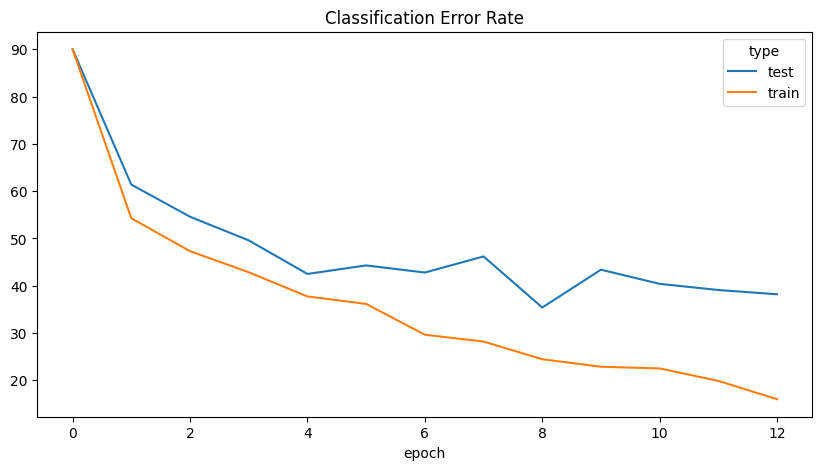

In [32]:
(
    pd.DataFrame(losses_and_errors)
    .pivot(index="epoch", columns="type", values="classification_error")
    .plot(title="Classification Error Rate", figsize=(10, 5))
)

<Axes: title={'center': 'Average Loss'}, xlabel='epoch'>

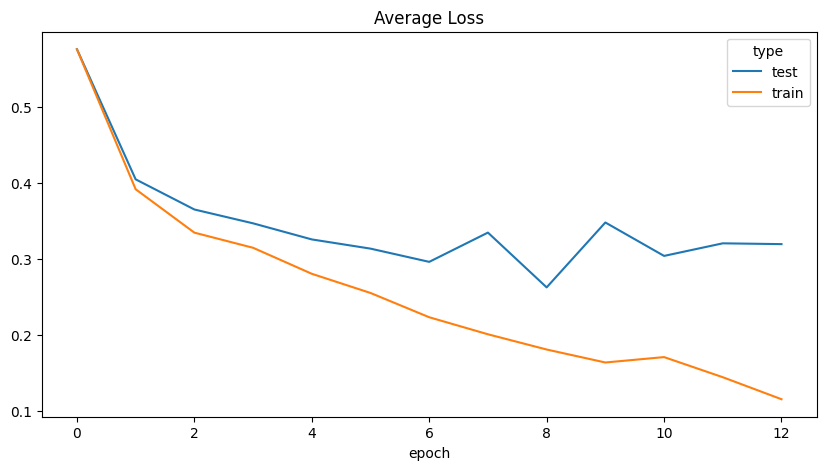

In [33]:
(
    pd.DataFrame(losses_and_errors)
    .pivot(index="epoch", columns="type", values="average_loss")
    .plot(title="Average Loss", figsize=(10, 5))
)